# Fitting SVG signal

In this notebook I will take a random sample of points from the SVG smoothed signal (created in Sunspot Data Plotting) and see if the Gaussian process can (essentially) fill in the rest of the points.

For this I will be using the ***qusi-periodic kernel function***, given by:

$$ k_{i,j} = A^2 \exp{\left[-\frac{(x_i-x_j)^2}{2 l_1^2} - \frac{\sin^2}{l^2_2}{\left(\frac{\pi (x_i - x_j)}{P} \right)} \right]} + \sigma^2 \delta_{ij}$$

A list of kernel functions for PyMC3 can be found at https://docs.pymc.io/en/v3/api/gp/cov.html

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pymc3 as pm
import scipy as sp
import arviz as az
import theano.tensor as tt

In [2]:
df = pd.read_csv('Data/SVG_poly1.csv') # importing data for SVG polyorder = 1
X = ((df.Year).values).reshape(-1,1)
y = (df.Sunspot_Number).values
yerr = np.zeros(len(X)) 

In [3]:
rng = np.random.RandomState(1) # random selection of points
training_indices = rng.choice(np.arange(y.size), size=200, replace=False)

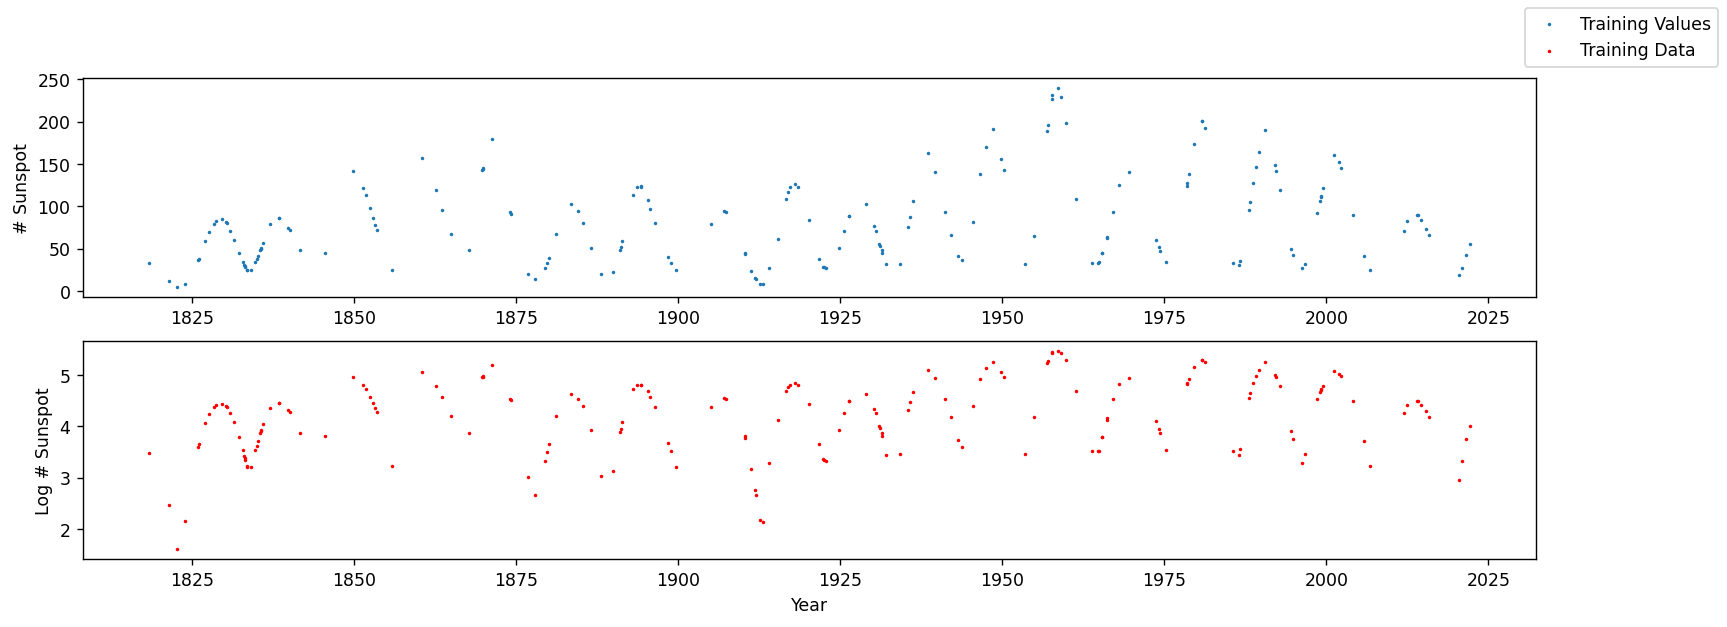

In [4]:
training_values = X[training_indices], y[training_indices]

training_data = training_values[0], np.log(training_values[1])  
# take logs to obtain positive definite values
X_train = training_data[0]
y_train = training_data[1]

fig, ax = plt.subplots(2, dpi=125, figsize=[15,5])

ax[0].scatter(training_values[0], training_values[1], label='Training Values', s=1)
ax[0].set_ylabel("# Sunspot")
ax[1].scatter(training_data[0], training_data[1], label='Training Data', s=1, color='red')
ax[1].set_ylabel("Log # Sunspot")
ax[1].set_xlabel('Year')
fig.legend();

Here we are taking a sample of points from our data (which contains over 70,000 datapoints). The training data represents most of the shape of the distribution, so we will observe how well it can be modelled using a Gaussian process.

PyMC3 doesn't contain the quasi-periodic kernel, but it *does* contain a **periodic kernel** as well as a **squared exponential kernel**, which we can multiply togehter to arrive at our desired kernel.

In [5]:
# Define Sinusoidal Mean Function
class SinusoidalMean:
    def __init__(self, amplitude):
        self.amplitude = amplitude
    
    def __call__(self, x):
        return self.amplitude * tt.sin(x[:, 0] * 2 * np.pi)

# Define the Gaussian Process
with pm.Model() as model:
    
    # Define the amplitude of the sinusoidal mean
    amplitude = pm.Gamma('amplitude', 2, 2)
    
    # Define the `Period' as a normal distribtion with mean = 11 years
    period = pm.Normal('Period', 11, 1)
    
    # Define the `Amplitude' as a gamma function
    A = pm.Gamma('A', 2, 2)
    
    # Define the `length scale 1' of the periodic kernel as a normal distribution with mean = 1 year
    length_scale1 = pm.Normal('Length Scale 1', 1, 1)  
    
    # Define the `length_scale 2' of the squared-exponential kernel as a normal distribution with mean = 9 years
    length_scale2 = pm.Normal('Length Scale 2', 9, 4)
    
    # Define the `Standard deviation' as a beta function
    sigma = pm.Beta('$\sigma$', 2, 2)
    
    # Define the periodic kernel
    cov_periodic = pm.gp.cov.Periodic(1, period=period, ls=length_scale1)
    
    # Define the squared-exponential kernel
    cov_SE = pm.gp.cov.ExpQuad(1, ls=length_scale2)
    
    # Define the quasi-periodic kernel
    cov_qp = A**2 * cov_SE * cov_periodic 
    
    sinusoidal_mean = SinusoidalMean(amplitude)
    
    gp = pm.gp.Marginal(cov_func=cov_qp, mean_func=sinusoidal_mean)  # implementation of the sum of a GP prior and noise

    y_ = gp.marginal_likelihood("y", X=X_train, y=y_train, noise=sigma)

    tr = pm.sample(return_inferencedata=True) # finds local maximimum 'a posteriori point' given a model

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [$\sigma$, Length Scale 2, Length Scale 1, A, Period, amplitude]


/opt/anaconda3/envs/mlp/lib/python3.8/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/opt/anaconda3/envs/mlp/lib/python3.8/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 520 seconds.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.


The above code required a lot of trial and error to see at which points the priors converge to their optimal values, and continued readjustment of priors eventually lead to the values we have below.

**Update:** I have created a custom mean function using *theano*. This mean function is sinusoidal, as opposed to the constant one which was being used previously. I have done this because I don't want my GP to tend to a constand value when it gets too far from the previous data point, as we expect the solar cycle to retain its general sinusoidal shape.

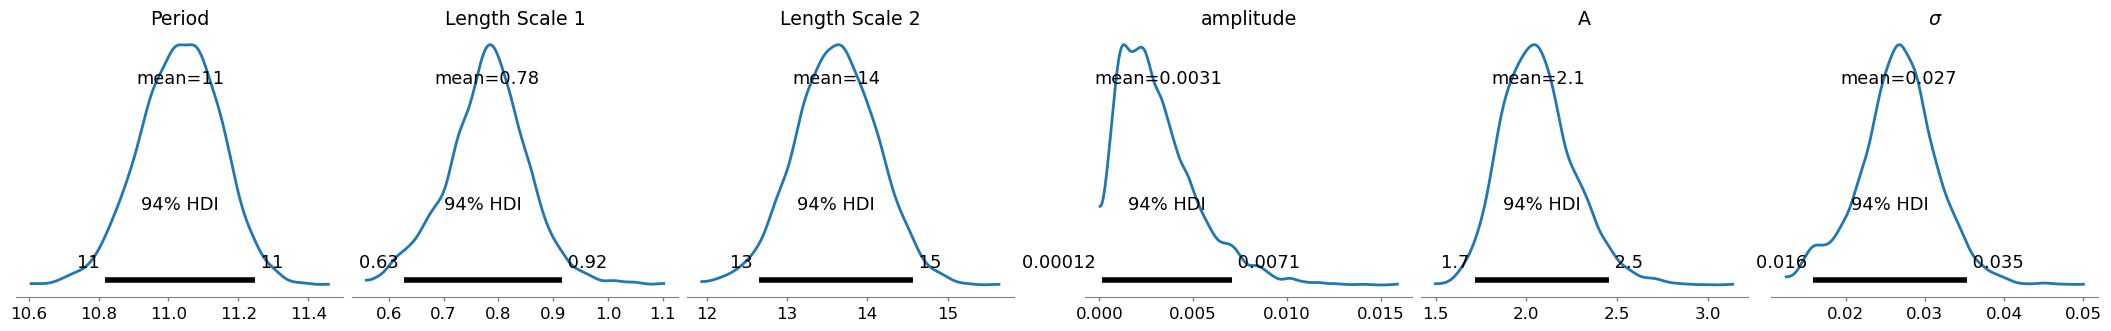

In [6]:
az.plot_posterior(tr, linewidth=2, c='tab:blue', figsize=(21,3.2), textsize=12, grid=(1,6));
#plt.savefig('gp post.png'); 

In [7]:
X_new = np.linspace(1800, 2055, 500)[:, None]
with model:
    fnew = gp.conditional("f_new", Xnew=X_new)

with model:
    ppc = pm.sample_posterior_predictive(tr, samples=1000, var_names=["f_new"])#

/opt/anaconda3/envs/mlp/lib/python3.8/site-packages/pymc3/sampling.py:1689: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  warnings.warn(


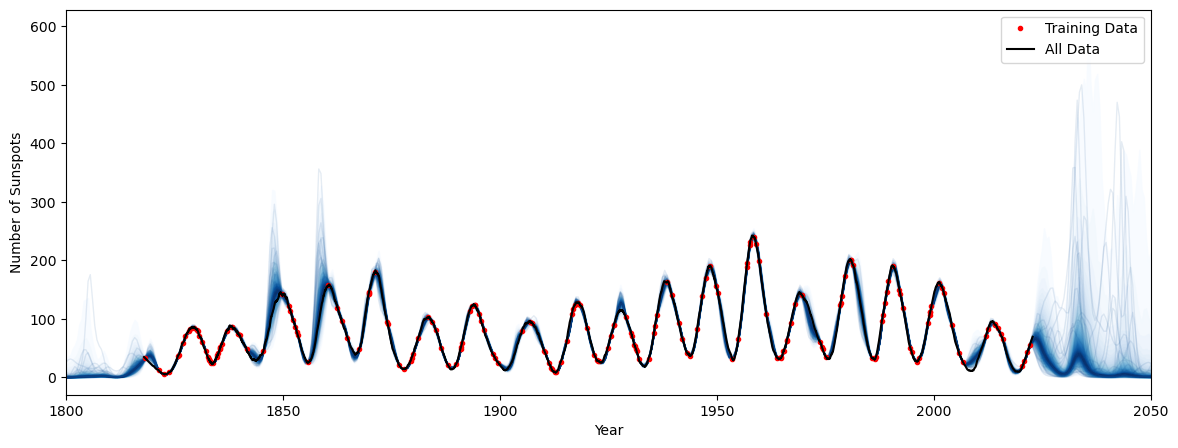

In [8]:
from pymc3.gp.util import plot_gp_dist

# draw plot
fig = plt.figure(figsize=(14, 5))
ax = fig.gca()
plot_gp_dist(ax, np.exp(ppc['f_new']), X_new, palette="Blues")
# np.exp() to return log value to normal value

# plot original data and GP
plt.plot(training_values[0], training_values[1], "or", ms=3, alpha=1.0, label="Training Data")
plt.plot(X, y, color="black", label="All Data")
plt.xlabel("Year")
plt.ylabel('Number of Sunspots')
plt.xlim(1800,2050)
plt.legend();
#plt.savefig('GD prediction');

#### Comment on plot:

Here we have used a ***quasi-periodic kernel*** consisting of only 200 data points. The GP does a very good job of modelling the data given the sparsity of data, however there is a recurrent issue with our parameter *length_scale1*, which is far too small and refuses to converge on anything else. This results in new predictions which do not show the same periodic behaivour, as the knowledge of the model essentially dies after that time.

**Edit**: Previously the GP was done using the 'training_values', but to ensure positive definiteness I have first taken the logarithm of the y-values, performed the GP, and then returned them back to standard sunspot number. As a result, the values for $A$, $\mu$ and $\sigma$ are all *logarithmic* values. This has improved the predictions made by the GP, as all predictions are plausible (as there are no negative sunspot numbers predicted).


### Forcing the parameters

In [9]:
with pm.Model() as model:
    
    period = pm.Normal('Period', 11, 1)
    ''' Parameters from above '''
    A = 0.67
    length_scale2 = 11
    sigma = 0.013
    length_scale1 = 11 # the 'forced' parameter
    
    cov_periodic = pm.gp.cov.Periodic(1, period=period, ls=length_scale1) # periodic kernel
    cov_SE = pm.gp.cov.ExpQuad(1, ls=length_scale2) # squared exponential kernel
    cov_qp = A**2 * cov_SE * cov_periodic # quasi-periodic kernel
    
    mu = 4.1 # note: using LogNormal makes no difference
    const_func = pm.gp.mean.Constant(mu)
    
    gp = pm.gp.Marginal(cov_func=cov_qp, mean_func=const_func)  # implementation of the sum of a GP prior and noise

    y_ = gp.marginal_likelihood("y", X=training_data[0], y=training_data[1], noise=sigma)

    tr = pm.sample(return_inferencedata=True) # finds local maximimum 'a posteriori point' given a model

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Period]


/opt/anaconda3/envs/mlp/lib/python3.8/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/opt/anaconda3/envs/mlp/lib/python3.8/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/opt/anaconda3/envs/mlp/lib/python3.8/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/opt/anaconda3/envs/mlp/lib/python3.8/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 178 seconds.


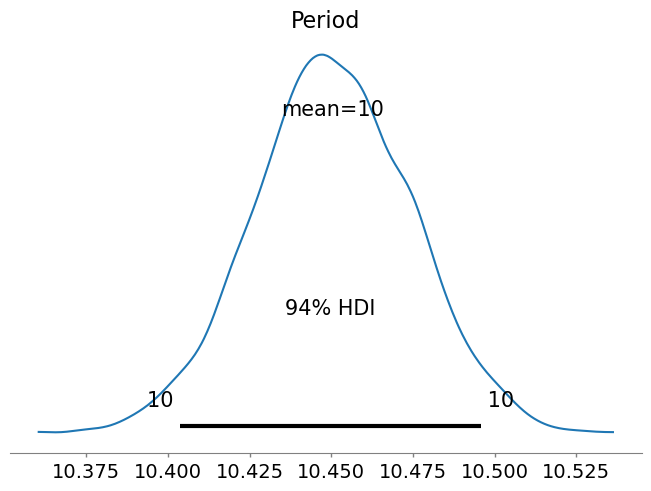

In [10]:
az.plot_posterior(tr);

In [11]:
X_new = np.linspace(1800, 2055, 500)[:, None]
with model:
    fnew = gp.conditional("f_new", Xnew=X_new)

with model:
    ppc = pm.sample_posterior_predictive(tr, samples=100, var_names=["f_new"])#

/opt/anaconda3/envs/mlp/lib/python3.8/site-packages/pymc3/sampling.py:1689: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  warnings.warn(


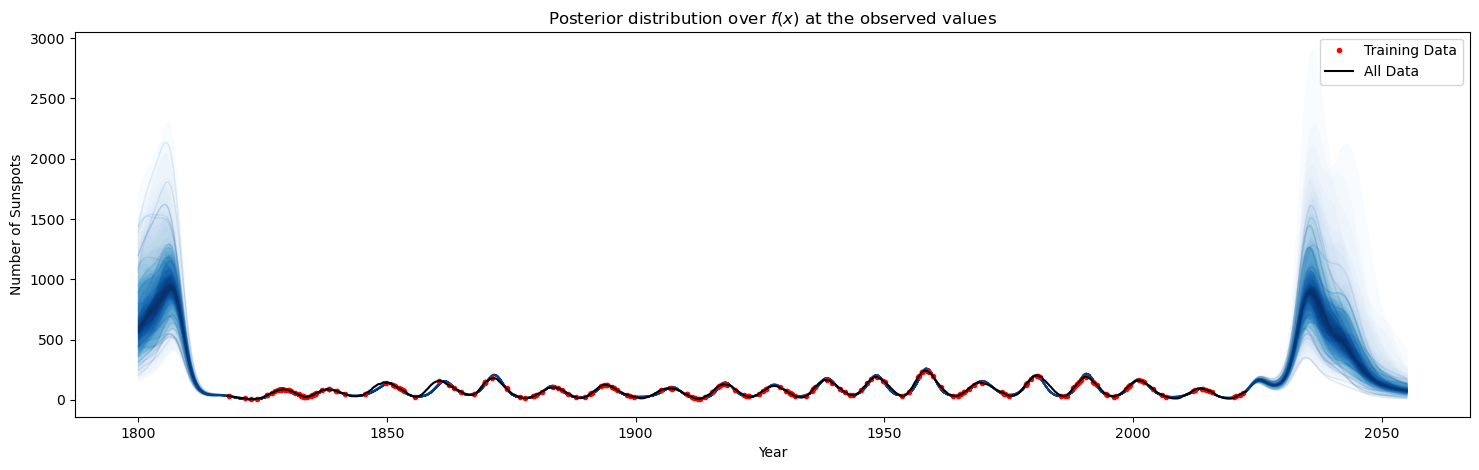

In [12]:
from pymc3.gp.util import plot_gp_dist

# draw plot
fig = plt.figure(figsize=(18, 5))
ax = fig.gca()
plot_gp_dist(ax, np.exp(ppc['f_new']), X_new, palette="Blues")

# plot original data and true function
plt.plot(training_values[0], training_values[1], "or", ms=3, alpha=1.0, label="Training Data")
plt.plot(X, y, color="black", label="All Data")

plt.xlabel("Year")
plt.ylabel('Number of Sunspots')
plt.title("Posterior distribution over $f(x)$ at the observed values")
plt.legend();

### Comment on plot:

For the above plot we have set most of the parameters as the values we obtained from the previous sampling, however I chose to 'force' the parameter for *length_scale1* to 11 years, so that the code would remember the shape of previous cycles for longer. This has not seemed to work. As we can see from the above plot, the predictions made do not seem plausible. 

The conclusion which can be drawn from this is that the solar cycles cannot be predicted years in advance. We are only able to predict with any sort of accuracy what the sunspot numbers would be in the next 6 months or so.
***

## Fitting with TensorFlow

At some point throughout this project I will want to create a neural network, which will involve the use of TensorFlow. Before creating the NN I first want to be able to use a GP with TF.

In [13]:
import matplotlib.pyplot as plt
import numpy as np
import time

In [14]:
import time

import numpy as np
import matplotlib.pyplot as plt
import tensorflow.compat.v2 as tf
import tensorflow_probability as tfp
tfb = tfp.bijectors
tfd = tfp.distributions
tfk = tfp.math.psd_kernels
tf.enable_v2_behavior()

from mpl_toolkits.mplot3d import Axes3D

2023-02-06 15:20:58.108981: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [15]:
def build_gp(amplitude, length_scale1, length_scale2, period, observation_noise_variance):
    """Defines the conditional dist. of GP outputs, given kernel parameters."""

  # Create the covariance kernel, which will be shared between the prior (which we
  # use for maximum likelihood training) and the posterior (which we use for
  # posterior predictive sampling)
    cov_SE = tfk.ExponentiatedQuadratic(amplitude, length_scale1)
    cov_P = tfk.ExpSinSquared(1, length_scale2, period)
    kernel = cov_SE * cov_P
    
  # Create the GP prior distribution, which we will use to train the model
  # parameters.
    return tfd.GaussianProcess(
      kernel=kernel,
      index_points=training_data[0],
      observation_noise_variance=observation_noise_variance)

gp_joint_model = tfd.JointDistributionNamed({
    'amplitude': tfd.LogNormal(loc=0., scale=np.float64(1.)),
    'period': tfd.LogNormal(loc=11., scale=np.float64(1.)),
    'length_scale1': tfd.LogNormal(loc=0., scale=np.float64(1.)),
    'length_scale2': tfd.LogNormal(loc=0., scale=np.float64(1.)),
    'observation_noise_variance': tfd.LogNormal(loc=0., scale=np.float64(1.)),
    'observations': build_gp,
})

2023-02-06 15:21:02.735961: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [16]:
x = gp_joint_model.sample()
lp = gp_joint_model.log_prob(x)

print("sampled {}".format(x))
print("log_prob of sample: {}".format(lp))

Instructions for updating:
`jitter` is deprecated; please use `marginal_fn` directly.
sampled {'period': <tf.Tensor: shape=(), dtype=float64, numpy=87143.12681431432>, 'observation_noise_variance': <tf.Tensor: shape=(), dtype=float64, numpy=0.9614644209583029>, 'length_scale2': <tf.Tensor: shape=(), dtype=float64, numpy=0.3148229453478514>, 'length_scale1': <tf.Tensor: shape=(), dtype=float64, numpy=2.677170281583857>, 'amplitude': <tf.Tensor: shape=(), dtype=float64, numpy=0.4932907162714995>, 'observations': <tf.Tensor: shape=(200,), dtype=float64, numpy=
array([-1.20923301,  0.83108131,  0.4031853 , -0.55408765, -2.20734704,
       -0.09100319, -0.60451228,  0.97368204,  0.56631989,  1.53938458,
       -0.04505533, -1.70449061,  0.50385093,  1.82170543,  1.1687544 ,
       -1.16819321,  0.60568343, -0.040643  ,  0.96605757, -1.50453043,
       -2.12085912, -0.96853668,  1.15937028,  1.28703505,  0.60044778,
        2.65873315, -0.96365547, -0.87797293,  1.99283089,  1.60270723,
    

In [17]:
# Create the trainable model parameters, which we'll subsequently optimize.
# Note that we constrain them to be strictly positive.

constrain_positive = tfb.Shift(np.finfo(np.float64).tiny)(tfb.Exp())

amplitude_var = tfp.util.TransformedVariable(
    initial_value=1.,
    bijector=constrain_positive,
    name='amplitude',
    dtype=np.float64)

length_scale1_var = tfp.util.TransformedVariable(
    initial_value=1.,
    bijector=constrain_positive,
    name='length_scale1',
    dtype=np.float64)

length_scale2_var = tfp.util.TransformedVariable(
    initial_value=1.,
    bijector=constrain_positive,
    name='length_scale2',
    dtype=np.float64)

period_var = tfp.util.TransformedVariable(
    initial_value=11.,
    bijector=constrain_positive,
    name='period',
    dtype=np.float64)

observation_noise_variance_var = tfp.util.TransformedVariable(
    initial_value=1.,
    bijector=constrain_positive,
    name='observation_noise_variance_var',
    dtype=np.float64)

trainable_variables = [v.trainable_variables[0] for v in 
                       [amplitude_var,
                       length_scale1_var,
                        length_scale2_var,
                        period_var,
                       observation_noise_variance_var]]

In [18]:
def target_log_prob(amplitude, length_scale1, length_scale2, period, observation_noise_variance):
    return gp_joint_model.log_prob({
      'amplitude': amplitude,
      'length_scale1': length_scale1,
        'length_scale2': length_scale2,
        'period': period,
      'observation_noise_variance': observation_noise_variance,
      'observations': training_data[1]
  })

In [19]:
num_results = 100
num_burnin_steps = 50

sampler = tfp.mcmc.TransformedTransitionKernel(
    tfp.mcmc.NoUTurnSampler(
        target_log_prob_fn=target_log_prob,
        step_size=tf.cast(0.1, tf.float64)),
    bijector=[constrain_positive, constrain_positive, constrain_positive, 
              constrain_positive, constrain_positive])

adaptive_sampler = tfp.mcmc.DualAveragingStepSizeAdaptation(
    inner_kernel=sampler,
    num_adaptation_steps=int(0.8 * num_burnin_steps),
    target_accept_prob=tf.cast(0.75, tf.float64))

initial_state = [tf.cast(x, tf.float64) for x in [1., 1., 1., 1., 1.]]

In [20]:
# Speed up sampling by tracing with `tf.function`.
@tf.function(autograph=False, jit_compile=False)
def do_sampling():
    return tfp.mcmc.sample_chain(
      kernel=adaptive_sampler,
      current_state=initial_state,
      num_results=num_results,
      num_burnin_steps=num_burnin_steps,
      trace_fn=lambda current_state, kernel_results: kernel_results)

t0 = time.time()
samples, kernel_results = do_sampling()
t1 = time.time()
print("Inference ran in {:.2f}s.".format(t1-t0))

2023-02-06 15:21:08.982175: W tensorflow/core/kernels/linalg/cholesky_op.cc:56] Cholesky decomposition was not successful. Eigen::LLT failed with error code 1. Filling lower-triangular output with NaNs.


Inference ran in 25.93s.


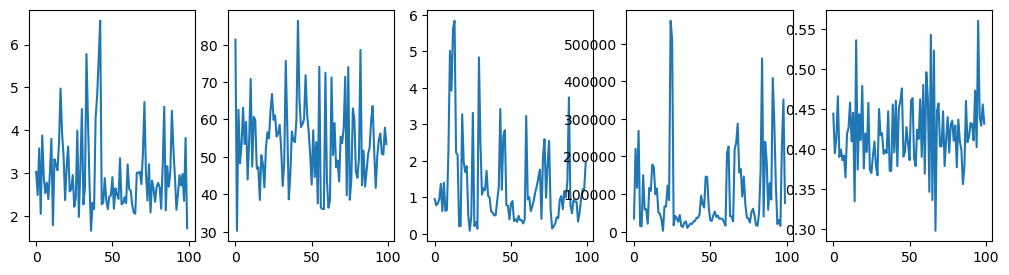

In [21]:
(amplitude_samples,
 length_scale1_samples,
 length_scale2_samples,
 period_samples,
 observation_noise_variance_samples) = samples

f = plt.figure(figsize=[15, 3])
for i, s in enumerate(samples):
    ax = f.add_subplot(1, len(samples) + 1, i + 1)
    ax.plot(s)

In [22]:
predictive_index_points_ = np.linspace(1800, 2055, 500)
# Reshape to [200, 1] -- 1 is the dimensionality of the feature space.
predictive_index_points_ = predictive_index_points_[..., np.newaxis]

In [23]:
# The sampled hyperparams have a leading batch dimension, `[num_results, ...]`,
# so they construct a *batch* of kernels.
batch_of_posterior_kernels = tfk.ExponentiatedQuadratic(
    amplitude_samples, length_scale1_samples) * tfk.ExpSinSquared(
    1, length_scale2_samples, period_samples)

# The batch of kernels creates a batch of GP predictive models, one for each
# posterior sample.
batch_gprm = tfd.GaussianProcessRegressionModel(
    kernel=batch_of_posterior_kernels,
    index_points=predictive_index_points_,
    observation_index_points=training_data[0],
    observations=training_data[1],
    observation_noise_variance=observation_noise_variance_var,
    predictive_noise_variance=0.)

# To construct the marginal predictive distribution, we average with uniform
# weight over the posterior samples.
predictive_gprm = tfd.MixtureSameFamily(
    mixture_distribution=tfd.Categorical(logits=tf.zeros([num_results])),
    components_distribution=batch_gprm)

num_samples = 100
samples = predictive_gprm.sample(num_samples)

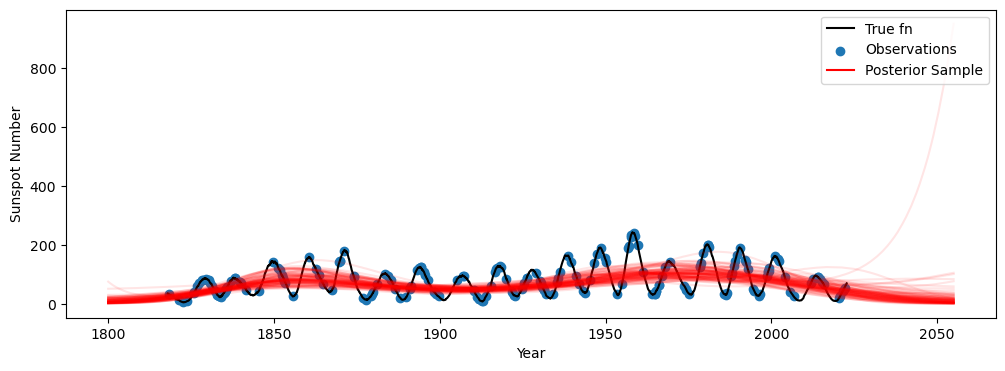

In [24]:
# Plot the true function, observations, and posterior samples.
plt.figure(figsize=(12, 4))
plt.plot(X, y,
         label='True fn', c='k')
plt.scatter(training_values[0], training_values[1],
            label='Observations')
for i in range(num_samples):
    plt.plot(predictive_index_points_, np.exp(samples[i, :]), c='r', alpha=.1,
           label='Posterior Sample' if i == 0 else None)
leg = plt.legend(loc='upper right')
for lh in leg.legendHandles: 
    lh.set_alpha(1)
plt.xlabel("Year")
plt.ylabel("Sunspot Number")
plt.show()

### Comment on plot:

TensorFlow is able to run much faster than PyMC3. This would be very useful when we are trying to build a deep and wide network. However, it seems to be more erratic than PyMC3 as some samples have extremely high amplitudes.

**Question**: How can we constrain the maximum sunspot number?

Try a sin^2(x) mean function